In [3]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from statsmodels.tsa.statespace.sarimax import SARIMAX
from statsmodels.tsa.seasonal import seasonal_decompose

In [4]:
data = pd.read_csv("ctr.csv")
print(data.head())

         Date  Clicks  Impressions
0  2022-10-19    2851        58598
1  2022-10-20    2707        57628
2  2022-10-21    2246        50135
3  2022-10-22    1686        40608
4  2022-10-23    1808        41999


In [5]:
# Data Preparation
data['Date'] = pd.to_datetime(data['Date'],format='%Y/%m/%d')
data.set_index('Date', inplace=True)

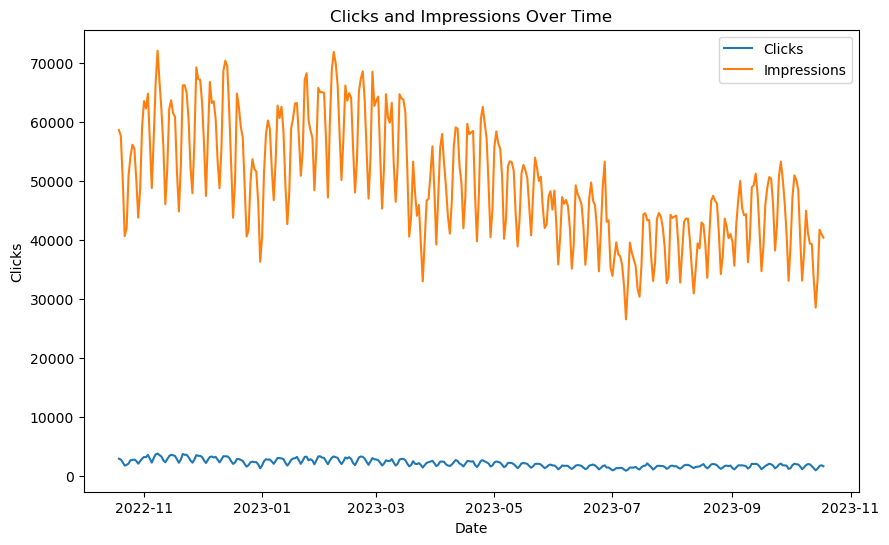

In [6]:


# Creating the plot
plt.figure(figsize=(10, 6))
sns.lineplot(x=data.index, y=data['Clicks'], label='Clicks')
sns.lineplot(x=data.index, y=data['Impressions'], label='Impressions')

# Setting the title
plt.title('Clicks and Impressions Over Time')

# Displaying the plot
plt.show()


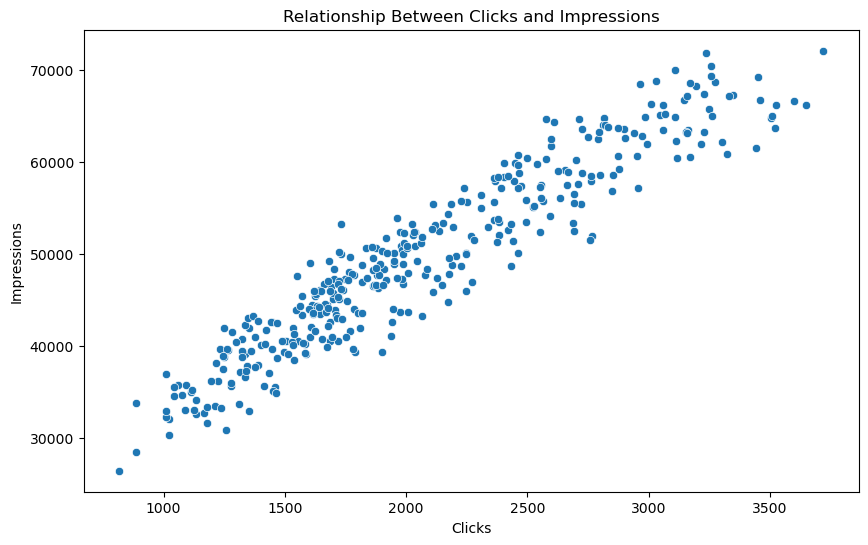

In [7]:


# Creating the plot
plt.figure(figsize=(10, 6))
sns.scatterplot(x='Clicks', y='Impressions', data=data)

# Setting the title and labels
plt.title('Relationship Between Clicks and Impressions')
plt.xlabel('Clicks')
plt.ylabel('Impressions')

# Displaying the plot
plt.show()


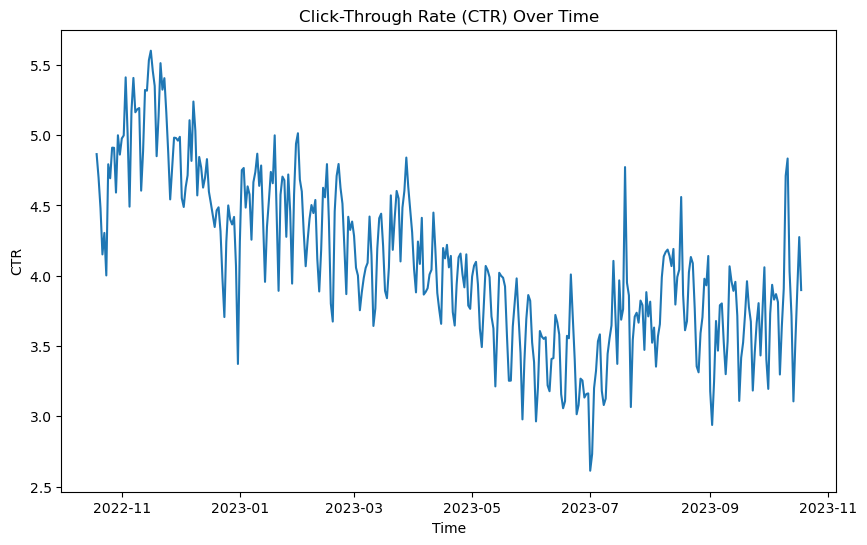

In [8]:


# Calculating the Click-Through Rate (CTR)
data['CTR'] = (data['Clicks'] / data['Impressions']) * 100

# Creating the plot
plt.figure(figsize=(10, 6))
sns.lineplot(x=data.index, y='CTR', data=data)

# Setting the title and labels
plt.title('Click-Through Rate (CTR) Over Time')
plt.xlabel('Time')
plt.ylabel('CTR')

# Displaying the plot
plt.show()


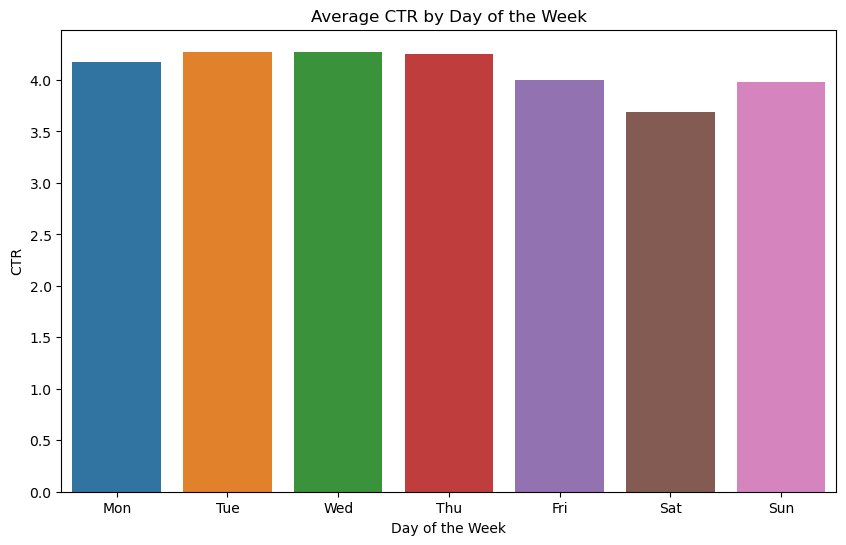

In [12]:
data['DayOfWeek'] = data.index.dayofweek


# Calculating the average CTR by day of the week
day_of_week_ctr = data.groupby('DayOfWeek')['CTR'].mean().reset_index()
day_of_week_ctr['DayOfWeek'] = ['Mon', 'Tue', 'Wed', 'Thu', 'Fri', 'Sat', 'Sun']

# Creating the plot
plt.figure(figsize=(10, 6))
sns.barplot(x='DayOfWeek', y='CTR', data=day_of_week_ctr)

# Setting the title and labels
plt.title('Average CTR by Day of the Week')
plt.xlabel('Day of the Week')
plt.ylabel('CTR')

# Displaying the plot
plt.show()


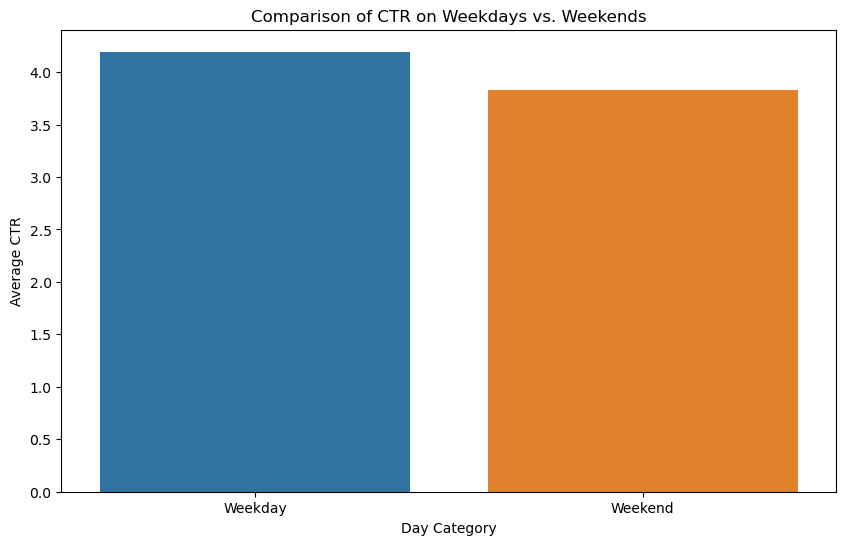

In [15]:
data['DayCategory'] = data['DayOfWeek'].apply(lambda x: 'Weekend' if x >= 5 else 'Weekday')

# Calculate average CTR for weekdays and weekends
ctr_by_day_category = data.groupby('DayCategory')['CTR'].mean().reset_index()

# Creating the plot
plt.figure(figsize=(10, 6))
sns.barplot(x='DayCategory', y='CTR', data=ctr_by_day_category)

# Setting the title and labels
plt.title('Comparison of CTR on Weekdays vs. Weekends')
plt.xlabel('Day Category')
plt.ylabel('Average CTR')

# Displaying the plot
plt.show()


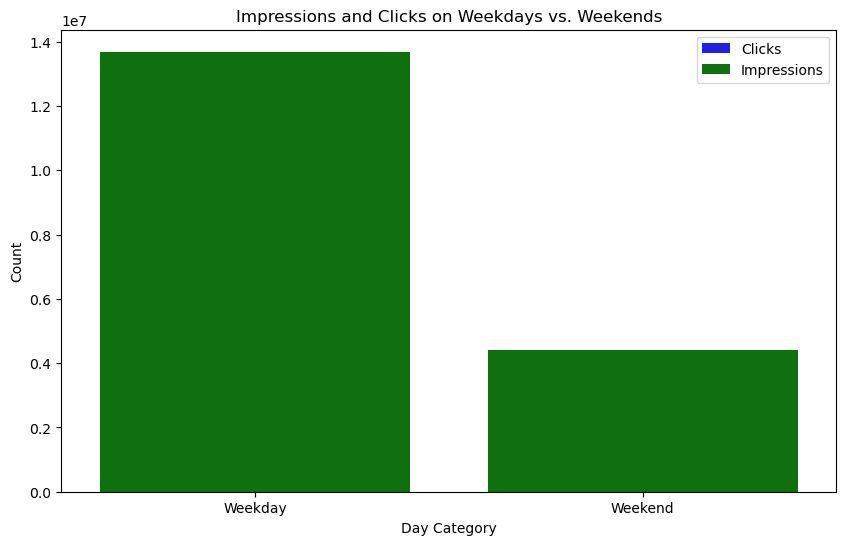

In [16]:


# Group the data by 'DayCategory' and calculate the sum of Clicks and Impressions for each category
grouped_data = data.groupby('DayCategory')[['Clicks', 'Impressions']].sum().reset_index()

# Create a grouped bar chart to visualize Clicks and Impressions on weekdays vs. weekends
plt.figure(figsize=(10, 6))
sns.barplot(x='DayCategory', y='Clicks', data=grouped_data, color='blue', label='Clicks')
sns.barplot(x='DayCategory', y='Impressions', data=grouped_data, color='green', label='Impressions')

# Customize the layout
plt.title('Impressions and Clicks on Weekdays vs. Weekends')
plt.xlabel('Day Category')
plt.ylabel('Count')
plt.legend()

# Show the plot
plt.show()


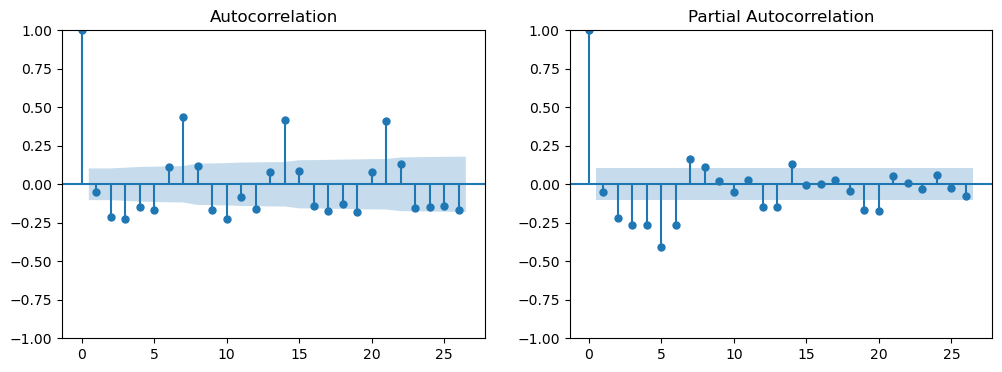

In [17]:
data.reset_index(inplace=True)

from statsmodels.tsa.arima.model import ARIMA
from statsmodels.graphics.tsaplots import plot_acf, plot_pacf

# resetting index
time_series = data.set_index('Date')['CTR']

# Differencing
differenced_series = time_series.diff().dropna()

# Plot ACF and PACF of differenced time series
fig, axes = plt.subplots(1, 2, figsize=(12, 4))
plot_acf(differenced_series, ax=axes[0])
plot_pacf(differenced_series, ax=axes[1])
plt.show()

In [19]:
from statsmodels.tsa.statespace.sarimax import SARIMAX

p, d, q, s = 1, 1, 1, 12

model = SARIMAX(time_series, order=(p, d, q), seasonal_order=(p, d, q, s))
results = model.fit()
print(results.summary())

C:\Users\vgund\anaconda3\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  self._init_dates(dates, freq)
C:\Users\vgund\anaconda3\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  self._init_dates(dates, freq)


                                     SARIMAX Results                                      
Dep. Variable:                                CTR   No. Observations:                  365
Model:             SARIMAX(1, 1, 1)x(1, 1, 1, 12)   Log Likelihood                 -71.365
Date:                            Thu, 22 Feb 2024   AIC                            152.729
Time:                                    12:53:43   BIC                            172.048
Sample:                                10-19-2022   HQIC                           160.417
                                     - 10-18-2023                                         
Covariance Type:                              opg                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
ar.L1          0.5265      0.070      7.512      0.000       0.389       0.664
ma.L1         -0.9049      0.036   

In [20]:
# Predict future values
future_steps = 100
predictions = results.predict(len(time_series), len(time_series) + future_steps - 1)
print(predictions)

2023-10-19    3.852360
2023-10-20    3.889441
2023-10-21    3.820283
2023-10-22    3.727498
2023-10-23    3.710355
                ...   
2024-01-22    3.545539
2024-01-23    3.466612
2024-01-24    3.561157
2024-01-25    3.546665
2024-01-26    3.580087
Freq: D, Name: predicted_mean, Length: 100, dtype: float64


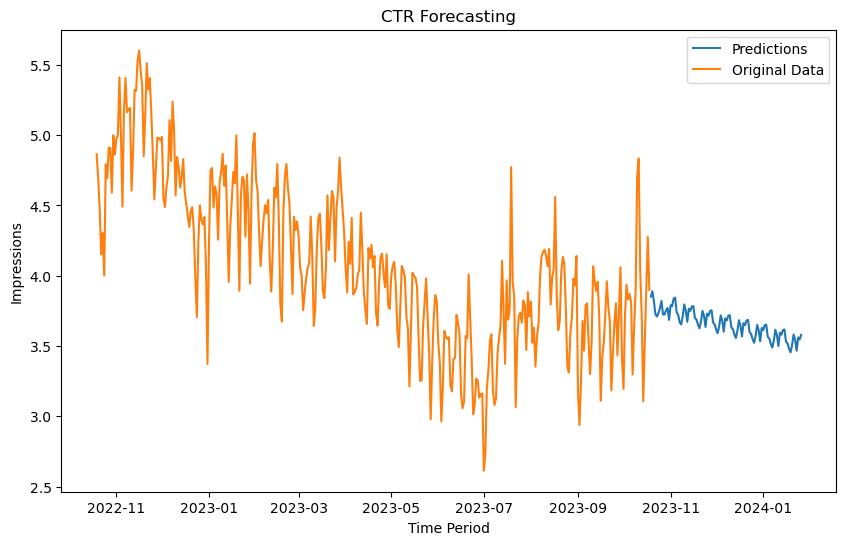

In [21]:


# Create a DataFrame with the original data and predictions
forecast = pd.DataFrame({'Original': time_series, 'Predictions': predictions})

# Plot the original data and predictions
plt.figure(figsize=(10, 6))
sns.lineplot(x=forecast.index, y='Predictions', data=forecast, label='Predictions')
sns.lineplot(x=forecast.index, y='Original', data=forecast, label='Original Data')

# Customize the layout
plt.title('CTR Forecasting')
plt.xlabel('Time Period')
plt.ylabel('Impressions')
plt.legend(loc='upper right')

# Show the plot
plt.show()
